In [1]:
import pandas as pd
import numpy as np
import os
import time
from dataclasses import dataclass, field
from typing import List, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.distributed as dist
from sklearn.metrics import roc_auc_score
import wandb

from transformers import (
    HfArgumentParser,
    PreTrainedTokenizerFast,
    T5GemmaForConditionalGeneration,  # NOTE: PLL needs logits => use *ForConditionalGeneration*
)

/gpfs/home/as12267/.conda/envs/huggingface_bert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def is_initialized() -> bool:
    return dist.is_available() and dist.is_initialized()

def get_rank() -> int:
    return dist.get_rank() if is_initialized() else 0

def get_world_size() -> int:
    return dist.get_world_size() if is_initialized() else 1

def all_gather_object(gathered, local):
    if is_initialized():
        dist.all_gather_object(gathered, local)
    else:
        gathered[0] = local

def maybe_init_distributed():
    # If launched with torchrun, these env vars exist
    if dist.is_available() and "RANK" in os.environ and not dist.is_initialized():
        backend = "nccl" if torch.cuda.is_available() else "gloo"
        dist.init_process_group(backend=backend)


In [13]:
ckpt = "/gpfs/data/brandeslab/model_checkpts/T5Gemma_97M_phylo_lr1e-4_bs256_ctxt_1024/checkpoint-3765"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = T5GemmaForConditionalGeneration.from_pretrained(ckpt).to(device)


In [10]:
from gLM.tokenizers import PhyloTokenizerLoader

tokenizer = PhyloTokenizerLoader("./phylo_char_tokenizer_updated")
pad_id = tokenizer.pad_token_id
gap_id = tokenizer.convert_tokens_to_ids("-")
print("Phylo Tokenizer loaded. pad ID:", pad_id)
print("Phylo Tokenizer loaded. GAP ID:", gap_id)
print(f"vocab size: {tokenizer.vocab_size}")

Phylo Tokenizer loaded. pad ID: 0
Phylo Tokenizer loaded. GAP ID: 6
vocab size: 27


In [18]:
clin_var = pd.read_csv("/gpfs/data/brandeslab/Data/clinvar_AA_zero_shot_input.csv")
clin_var['seq_length'] = clin_var['sequence'].str.len()
# bottom 8 seqeunces 
bottom_8 = clin_var.sort_values('seq_length', ascending=True).reset_index(drop=True).head(8)

bottom_8


,sequence,pos,ref,alt,label,seq_length
0,MSYYGNYYGGLGYGYDCKYSYTSGFGAFRILDCGYRCGCGGVWI,8,G,R,0,44
1,MKFFVFALILALMLSMTGADSHAKRHHGYKRKFHEKHHSHRGYRSN...,16,T,I,0,51
2,MVAYWRQAGLSYIRYSQICAKAVRDALKTEFKANAEKTSGSNVKIV...,28,T,K,0,51
3,MCYGYGCGCGSFCRLGYGCGYEGCRYGCGHRGCGDGCCCPSCYRRY...,48,T,S,0,52
4,MCSYYHMKKRSVSGCNITIFAVMFSHLSAGKSPCGNQANVLCISRL...,12,S,L,0,53
5,MCTTLFLLSTLAMLWRRRFANRVQPEPSDVDGAARGSSLDADPQSS...,16,R,C,0,54
6,MCTTLFLLSTLAMLWRRRFANRVQPEPSDVDGAARGSSLDADPQSS...,0,M,T,1,54
7,MVKLSKEAKQRLQQLFKGSQFAIRWGFIPLVIYLGFKRGADPGMPE...,24,W,R,1,55


In [25]:
def shift_right(input_ids: torch.Tensor, start_id: int, pad_id: int) -> torch.Tensor:
    """
    
    Build decoder inputs for teacher forcing (autoregressive decoding).

    We want the decoder to predict token t using only tokens < t as context.
    So we create a "shifted-right" version of the target sequence:

      - Same shape in/out: [B, T]
      - The first decoder input is a special start token (decoder_start_token_id)
      - Everything else is the target sequence shifted right by 1 position

    Concretely, for a target sequence y = [y0, y1, ..., y(T-1)]:

      decoder_input_ids = [<start>, y0, y1, ..., y(T-2)]   # length T
      labels            = [y0,      y1, y2, ..., y(T-1)]   # length T

    This keeps decoder_input_ids and labels aligned in time:
    logits[:, t] corresponds to predicting labels[:, t] given decoder_input_ids[:, :t].

    input_ids: LongTensor [B, T]
    returns:   LongTensor [B, T]
      out[:,0] = start_id
      out[:,1:] = input_ids[:,:-1]
    """
    B, T = input_ids.shape
    shifted = input_ids.new_zeros((B, T))
    # print("shifted", shifted)
    shifted[:, 0] = start_id
    # print("shifted after setting start_id", shifted)
    shifted[:, 1:] = input_ids[:, :-1]
    # print("shifted after shifting", shifted)
    # shifted = shifted.masked_fill(shifted == -100, pad_id)
    # print("shifted after masking -100 with pad_id", shifted)
    return shifted

bottom_8_tok = tokenizer(
    bottom_8['sequence'].tolist(),
    padding='longest',
    truncation=True,
    max_length=1024,
    return_tensors='pt'
)
bottom_8_tok
print("bottom_8_tok shape", bottom_8_tok['input_ids'].shape) # [8, 55]

decoder_start_id = getattr(model.config, "decoder_start_token_id", None)
print("decoder_start_id", decoder_start_id) 

decoder_input_ids = shift_right(bottom_8_tok['input_ids'], decoder_start_id, pad_id)
print("decoder_input_ids shape", decoder_input_ids.shape) 
decoder_input_ids

# single_tok = tokenizer(
#     bottom_8.loc[1, "sequence"],   # or bottom_8["sequence"].iloc[1]
#     padding='longest',
#     truncation=True,
#     max_length=1024,
#     return_tensors='pt'
# )


# single_tok
# print("single_tok_tok shape", single_tok['input_ids'].shape) # [8, 55]

# decoder_start_id = getattr(model.config, "decoder_start_token_id", None)
# print("decoder_start_id", decoder_start_id) 

# decoder_input_ids = shift_right(single_tok['input_ids'], decoder_start_id, pad_id)
# print("decoder_input_ids shape", decoder_input_ids.shape) 
# decoder_input_ids

bottom_8_tok shape torch.Size([8, 55])
decoder_start_id 0
decoder_input_ids shape torch.Size([8, 55])


tensor([[ 0, 17, 22, 26, 26, 12, 18, 26, 26, 12, 12, 16, 12, 26, 12, 26,  9,  8,
         15, 26, 22, 26, 23, 22, 12, 11, 12,  7, 11, 21, 14, 16,  9,  8, 12, 26,
         21,  8, 12,  8, 12, 12, 24, 25, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0],
        [ 0, 17, 15, 11, 11, 24, 11,  7, 16, 14, 16,  7, 16, 17, 16, 22, 17, 23,
         12,  7,  9, 22, 13,  7, 15, 21, 13, 13, 12, 26, 15, 21, 15, 11, 13, 10,
         15, 13, 13, 22, 13, 21, 12, 26, 21, 22, 18, 26, 16, 26,  9, 18,  0,  0,
          0],
        [ 0, 17, 24,  7, 26, 25, 21, 20,  7, 12, 16, 22, 26, 14, 21, 26, 22, 20,
         14,  8,  7, 15,  7, 24, 21,  9,  7, 16, 15, 23, 10, 11, 15,  7, 18,  7,
         10, 15, 23, 22, 12, 22, 18, 24, 15, 14, 24, 15, 24, 15, 15, 10,  0,  0,
          0],
        [ 0, 17,  8, 26, 12, 26, 12,  8, 12,  8, 12, 22, 11,  8, 21, 16, 12, 26,
         12,  8, 12, 26, 10, 12,  8, 21, 26, 12,  8, 12, 13, 21, 12,  8, 12,  9,
         12,  8,  8,  8, 19, 22,  8, 26, 21, 21, 26, 21, 11, 23, 12

In [32]:
single_tok = tokenizer(
    bottom_8.loc[1, "sequence"],   # or bottom_8["sequence"].iloc[1]
    padding='longest',
    truncation=True,
    max_length=1024,
    return_tensors='pt'
)
single_tok

{'input_ids': tensor([[17, 15, 11, 11, 24, 11,  7, 16, 14, 16,  7, 16, 17, 16, 22, 17, 23, 12,
          7,  9, 22, 13,  7, 15, 21, 13, 13, 12, 26, 15, 21, 15, 11, 13, 10, 15,
         13, 13, 22, 13, 21, 12, 26, 21, 22, 18, 26, 16, 26,  9, 18]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

In [16]:
bottom_8_tok['input_ids']

tensor([[17, 22, 26, 26, 12, 18, 26, 26, 12, 12, 16, 12, 26, 12, 26,  9,  8, 15,
         26, 22, 26, 23, 22, 12, 11, 12,  7, 11, 21, 14, 16,  9,  8, 12, 26, 21,
          8, 12,  8, 12, 12, 24, 25, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0],
        [17, 15, 11, 11, 24, 11,  7, 16, 14, 16,  7, 16, 17, 16, 22, 17, 23, 12,
          7,  9, 22, 13,  7, 15, 21, 13, 13, 12, 26, 15, 21, 15, 11, 13, 10, 15,
         13, 13, 22, 13, 21, 12, 26, 21, 22, 18, 26, 16, 26,  9, 18,  0,  0,  0,
          0],
        [17, 24,  7, 26, 25, 21, 20,  7, 12, 16, 22, 26, 14, 21, 26, 22, 20, 14,
          8,  7, 15,  7, 24, 21,  9,  7, 16, 15, 23, 10, 11, 15,  7, 18,  7, 10,
         15, 23, 22, 12, 22, 18, 24, 15, 14, 24, 15, 24, 15, 15, 10,  0,  0,  0,
          0],
        [17,  8, 26, 12, 26, 12,  8, 12,  8, 12, 22, 11,  8, 21, 16, 12, 26, 12,
          8, 12, 26, 10, 12,  8, 21, 26, 12,  8, 12, 13, 21, 12,  8, 12,  9, 12,
          8,  8,  8, 19, 22,  8, 26, 21, 21, 26, 21, 11, 23, 12, 11

In [53]:
@torch.no_grad()
def pll_batch_seq2seq(model, tokenizer, seqs: List[str], max_len: int) -> torch.Tensor:
    """
    PLL(s) = sum_t log P(s_t | s_<t, encoder(s)) for each sequence.
    Returns: FloatTensor [B]
    """
    device = next(model.parameters()).device

    # tok = tokenizer(
    #     list(seqs),
    #     return_tensors="pt",
    #     padding="longest",
    #     truncation=True,
    #     max_length=max_len,
    #     add_special_tokens=False,
    # ).to(device)
    tok = tokenizer(
        seqs,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=max_len,
        add_special_tokens=False,
    ).to(device)

    input_ids = tok["input_ids"]            # [B, T]
    attention_mask = tok["attention_mask"]  # [B, T]

    labels = input_ids.clone()
    labels = labels.masked_fill(attention_mask == 0, -100)
    print("encoder inputs shape", input_ids.shape)
    print(input_ids)
    print("encoder attention mask shape", attention_mask.shape)
    pad_id = tokenizer.pad_token_id
    enc_sum_expected = (input_ids != pad_id).sum()
    # Encoder mask sum equals the total number of non-pad tokens in input_ids
    print("enc_sum expected:", enc_sum_expected.item())
    print("enc_sum actual:  ", attention_mask.sum().item())

    print("labels shape", labels.shape)

    decoder_start_id = getattr(model.config, "decoder_start_token_id", None)
    if decoder_start_id is None:
        decoder_start_id = tokenizer.pad_token_id

    decoder_input_ids = shift_right(input_ids, decoder_start_id, tokenizer.pad_token_id)  # [B,T]
    print("decoder_input_ids shape", decoder_input_ids.shape)
    decoder_attention_mask = shift_right(attention_mask, 1, 0)                            # [B,T]
    print("decoder_attention_mask shape", decoder_attention_mask.shape)
    print("decoder_attention_mask_sum", decoder_attention_mask.sum()) # decoder_sum=encoder_sum+B−#(rows where last token is real)
    B, T = attention_mask.shape

    last_is_real = attention_mask[:, -1].sum().item()     # how many rows have a real token at last column
    dec_sum_expected = attention_mask.sum().item() + B - last_is_real

    print("B:", B)
    print("last_is_real rows:", last_is_real)
    print("dec_sum expected:", dec_sum_expected)
    print("dec_sum actual:  ", decoder_attention_mask.sum().item())

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
    )

    logits = outputs.logits                 # [B, T, V]  <-- requires *ForConditionalGeneration*
    print("logits shape", logits.shape)
    # print("logits", logits)
    log_probs = F.log_softmax(logits, -1)   # [B, T, V]
    print("log_probs shape", log_probs.shape)
    # print("log_probs", log_probs)

    gather_labels = labels.clone()
    gather_labels[gather_labels == -100] = 0
    print("gather_labels shape", gather_labels.shape)
    # print("gather_labels", gather_labels)

    token_logp = log_probs.gather(
        dim=-1, index=gather_labels.unsqueeze(-1)  # [B, T, 1]
    ).squeeze(-1)                                   # [B, T]
    print("token_logp shape", token_logp.shape)
    # print("token_logp", token_logp)
    token_logp = token_logp * (labels != -100).to(token_logp.dtype)  # [B, T]
    print("token_logp after masking shape", token_logp.shape)
    # print("token_logp after masking", token_logp)
    sum = token_logp.sum(dim=1) # B
    print("sum shape", sum.shape)
    # print("sum", sum)
    return sum # [B]
    

# bottom_8_pll = pll_batch_seq2seq(model, tokenizer, bottom_8['sequence'].tolist(), max_len=1024)

# single_tok_pll = pll_batch_seq2seq(model, tokenizer, bottom_8.loc[7, "sequence"], max_len=1024)

In [ ]:
@torch.no_grad()
def pll_batch_seq2seq_conditional(
    model,
    tokenizer,
    encoder_seqs: List[str],
    target_seqs: List[str],
    max_len: int,
) -> torch.Tensor:
    """
    Compute PLL(target | encoder) in batch.

    PLL = sum_t log P(target_t | target_<t, encoder(encoder_seq))

    encoder_seqs: list[str] length B
    target_seqs:  list[str] length B
    returns: FloatTensor [B]
    """
    assert len(encoder_seqs) == len(target_seqs), "encoder_seqs and target_seqs must match length"
    device = next(model.parameters()).device

    # --- tokenize encoder side ---
    enc = tokenizer(
        encoder_seqs,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=max_len,
        add_special_tokens=False,
    ).to(device)
    enc_input_ids = enc["input_ids"]              # [B, Tenc]
    enc_attention_mask = enc["attention_mask"]    # [B, Tenc]

    # --- tokenize decoder/target side ---
    dec = tokenizer(
        target_seqs,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=max_len,
        add_special_tokens=False,
    ).to(device)
    tgt_input_ids = dec["input_ids"]              # [B, Tdec]
    tgt_attention_mask = dec["attention_mask"]    # [B, Tdec]

    # labels: ignore pad positions in the loss / gathering
    labels = tgt_input_ids.clone()
    labels = labels.masked_fill(tgt_attention_mask == 0, -100)  # [B, Tdec]

    decoder_start_id = getattr(model.config, "decoder_start_token_id", None)
    if decoder_start_id is None:
        decoder_start_id = tokenizer.pad_token_id
    pad_id = tokenizer.pad_token_id

    decoder_input_ids = shift_right(tgt_input_ids, decoder_start_id, pad_id)  # [B, Tdec]

    # decoder attention: 1 for positions the decoder is allowed to attend to.
    # We want the "start" position to be attended, and pads to be off.
    decoder_attention_mask = shift_right(tgt_attention_mask, 1, 0)            # [B, Tdec]

    outputs = model(
        input_ids=enc_input_ids,
        attention_mask=enc_attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
    )

    logits = outputs.logits                         # [B, Tdec, V]
    log_probs = F.log_softmax(logits, dim=-1)       # [B, Tdec, V]

    # gather log prob of the true token at each position
    gather_labels = labels.clone()
    gather_labels[gather_labels == -100] = 0        # safe index for gather
    token_logp = log_probs.gather(
        dim=-1, index=gather_labels.unsqueeze(-1)   # [B, Tdec, 1]
    ).squeeze(-1)                                   # [B, Tdec]

    # zero out pad positions (where labels == -100)
    token_logp = token_logp * (labels != -100).to(token_logp.dtype)

    return token_logp.sum(dim=1)                    # [B]


In [36]:
len(bottom_8.loc[1, "sequence"])

51

In [ ]:
# Interpretation:
# For the 7 sequences shorter than 55, the last column was PAD (0) in the encoder mask, so when you shift-right and insert a start token mask 1, you gain +1 per such row.
# For the 1 sequence of length 55, the last column was already real (1), so shifting drops that 1 but adds the start 1 → net 0 change.


In [55]:
def compute_pll_diff_encoder_decoder(model, tokenizer, seqs, poses, refs, alts, max_len: int):
    """
    ΔPLL = PLL(mut) - PLL(wt)
    Returns: list[float|None] aligned to input order
    """
    results = [None] * len(seqs)
    valid_data = []

    for i, (seq, pos, ref, alt) in enumerate(zip(seqs, poses, refs, alts)):
        if len(seq) <= max_len and 0 <= pos < len(seq) and seq[pos] == ref:
            ref_id = tokenizer.convert_tokens_to_ids(ref)
            alt_id = tokenizer.convert_tokens_to_ids(alt)
            if ref_id is None or alt_id is None:
                continue
            valid_data.append((i, seq, pos, alt))

    if not valid_data:
        return results

    indices = [x[0] for x in valid_data]
    wt_seqs  = [x[1] for x in valid_data]
    poses_v  = [x[2] for x in valid_data]
    alts_v   = [x[3] for x in valid_data]

    mut_seqs = [wt[:pos] + alt + wt[pos + 1:] for wt, pos, alt in zip(wt_seqs, poses_v, alts_v)]

    wt_pll  = pll_batch_seq2seq(model, tokenizer, wt_seqs,  max_len=max_len)  # [B]
    print("wt_pll", wt_pll)
    mut_pll = pll_batch_seq2seq(model, tokenizer, mut_seqs, max_len=max_len)  # [B]
    print("mut_pll", mut_pll)


    delta = (mut_pll - wt_pll).tolist()
    for idx, d in zip(indices, delta):
        results[idx] = float(d)
    return results

# delta_pll_results = compute_pll_diff_encoder_decoder(
#     model, tokenizer,
#     seqs=[bottom_8.loc[7, "sequence"]],
#     poses=[int(bottom_8.loc[7, "pos"])],   # make sure it's int
#     refs=[bottom_8.loc[7, "ref"]],
#     alts=[bottom_8.loc[7, "alt"]],
#     max_len=1024
# )

# print(delta_pll_results)        # list aligned to input order (length 1)
# print(delta_pll_results[0])     # the scalar delta PLL


delta_pll_results = compute_pll_diff_encoder_decoder(
    model, tokenizer,
    seqs=bottom_8['sequence'].tolist(),  # convert tensor to list of lists
    poses=bottom_8["pos"].tolist(),   # make sure it's int
    refs=bottom_8["ref"].tolist(),
    alts=bottom_8["alt"].tolist(),
    max_len=1024
)

print(delta_pll_results)        # list aligned to input order (length 1)
print(delta_pll_results[0])  

encoder inputs shape torch.Size([8, 55])
tensor([[17, 22, 26, 26, 12, 18, 26, 26, 12, 12, 16, 12, 26, 12, 26,  9,  8, 15,
         26, 22, 26, 23, 22, 12, 11, 12,  7, 11, 21, 14, 16,  9,  8, 12, 26, 21,
          8, 12,  8, 12, 12, 24, 25, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0],
        [17, 15, 11, 11, 24, 11,  7, 16, 14, 16,  7, 16, 17, 16, 22, 17, 23, 12,
          7,  9, 22, 13,  7, 15, 21, 13, 13, 12, 26, 15, 21, 15, 11, 13, 10, 15,
         13, 13, 22, 13, 21, 12, 26, 21, 22, 18, 26, 16, 26,  9, 18,  0,  0,  0,
          0],
        [17, 24,  7, 26, 25, 21, 20,  7, 12, 16, 22, 26, 14, 21, 26, 22, 20, 14,
          8,  7, 15,  7, 24, 21,  9,  7, 16, 15, 23, 10, 11, 15,  7, 18,  7, 10,
         15, 23, 22, 12, 22, 18, 24, 15, 14, 24, 15, 24, 15, 15, 10,  0,  0,  0,
          0],
        [17,  8, 26, 12, 26, 12,  8, 12,  8, 12, 22, 11,  8, 21, 16, 12, 26, 12,
          8, 12, 26, 10, 12,  8, 21, 26, 12,  8, 12, 13, 21, 12,  8, 12,  9, 12,
          8,  8,  8, 19, 2

In [50]:
print(list(bottom_8.loc[7, "sequence"]))
print(bottom_8.loc[7, "pos"])
print(list(bottom_8.loc[7, 'ref']))
print(list(bottom_8.loc[7,'alt']))

['M', 'V', 'K', 'L', 'S', 'K', 'E', 'A', 'K', 'Q', 'R', 'L', 'Q', 'Q', 'L', 'F', 'K', 'G', 'S', 'Q', 'F', 'A', 'I', 'R', 'W', 'G', 'F', 'I', 'P', 'L', 'V', 'I', 'Y', 'L', 'G', 'F', 'K', 'R', 'G', 'A', 'D', 'P', 'G', 'M', 'P', 'E', 'P', 'T', 'V', 'L', 'S', 'L', 'L', 'W', 'G']
24
['W']
['R']


In [5]:

def run_vep_eval(df: pd.DataFrame, model, tokenizer, batch_size: int, max_len: int, step_id: int, log_wandb: bool):
    rank = get_rank()
    world_size = get_world_size()
    print(f"[Rank {rank}] Starting PLL VEP eval @ step {step_id}", flush=True)

    seqs = df["sequence"].values
    poses = df["pos"].values
    refs = df["ref"].values
    alts = df["alt"].values
    labels = df["label"].to_numpy(dtype=np.int8)

    n = len(labels)
    indices = np.arange(n)
    shard_indices = indices[rank::world_size]
    preds_shard = np.full(len(shard_indices), np.nan, dtype=np.float32)

    was_training = model.training
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        for i in range(0, len(shard_indices), batch_size):
            batch_ids = shard_indices[i:i + batch_size]
            batch_delta = compute_pll_diff_encoder_decoder(
                model=model,
                tokenizer=tokenizer,
                seqs=seqs[batch_ids],
                poses=poses[batch_ids],
                refs=refs[batch_ids],
                alts=alts[batch_ids],
                max_len=max_len,
            )

            for j, delta in enumerate(batch_delta):
                if delta is not None:
                    preds_shard[i + j] = -float(delta)  # higher = more pathogenic

            if (i % 20000) == 0:
                print(f"[Rank {rank}] Progress: {i}/{len(shard_indices)}", flush=True)

    if was_training:
        model.train()

    gathered_data = [None for _ in range(world_size)]
    local_data = list(zip(
        shard_indices.tolist(),
        preds_shard.tolist(),
        labels[shard_indices].tolist(),
    ))
    all_gather_object(gathered_data, local_data)

    if rank == 0:
        flat_preds = np.full(n, np.nan, dtype=np.float32)
        for data in gathered_data:
            for idx, pred, _ in data:
                flat_preds[idx] = pred

        mask = ~np.isnan(flat_preds)
        if mask.sum() >= 10 and (labels[mask].min() != labels[mask].max()):
            auc = roc_auc_score(labels[mask], flat_preds[mask])
            print(f"AUC (PLL) at step {step_id}: {auc:.4f}", flush=True)

            if log_wandb:
                wandb.log({
                    "zero_shot_vep_auc_pll": auc,
                    "step": step_id,
                    "elapsed_hours": (time.time() - start_time) / 3600.0,
                })
        else:
            print(f"Skipping AUC at step {step_id} due to insufficient data", flush=True)

        print(f"[TIMER] VEP eval took {time.time() - start_time:.2f} seconds", flush=True)


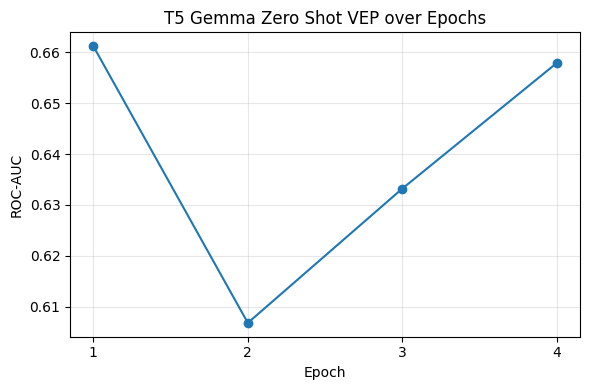

In [4]:
import matplotlib.pyplot as plt

roc_auc = {"epoch": [1, 2, 3, 4], "auc_pll": [0.6612, 0.6068, 0.6332, 0.6579]}

plt.figure(figsize=(6,4))
plt.plot(roc_auc["epoch"], roc_auc["auc_pll"], marker="o")
plt.title("T5 Gemma Zero Shot VEP over Epochs")
plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
# plt.ylim(0, 1)          
plt.xticks(roc_auc["epoch"])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
